In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.01
m1 = 0.
s0 = 0.5
dim = [1,2]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

# PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)
k = dim[0] * dim[1]
with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
    lowerd = DFlow([Linear(dim=k*(k-1)//2 + k, name='lowerd_flow')])
    ldiag = DFlow([Linear(dim=k, name='ldiag_flow')])
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
                   lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))

In [3]:
def autoregr(X, param):
    d = param[:,:dim[-1]-1]
    X = np.matmul(X, d) + param[:,-1][np.newaxis] + np.random.normal(size=[1,dim[-1]-1], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [4]:
xs = [np.random.normal(size=[1,dim[0]])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.concatenate(xs)[np.newaxis].astype(floatX)

In [5]:
xs[:,:6]

array([[[ 1.03380073],
        [-0.5918482 ],
        [-0.54354248],
        [-0.83599905],
        [-0.78511876],
        [-0.74559205]]])

In [6]:
# conf = [[ResFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)), 
#          NVPFlow(dim=n*dim[0]*dim[1], name='nvp{}'.format(i))] for i in range(2)]
# conf = sum(conf, [])

#conf = [NVPFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)) for i in range(4)]
conf = [Linear(dim=n*dim[0]*dim[1])]
# conf = [CFlow(dim=n*dim[0]*dim[1], name='CFlow')]

output_flow = DFlow(conf)
outputs = tf.reshape(output_flow.output, [1,n,dim[0]*dim[1]])

In [7]:
outputs

<tf.Tensor 'Reshape:0' shape=(1, 32, 2) dtype=float64>

In [8]:
prior = PWalk.logdens(outputs)

In [9]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [10]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [11]:
logl = create_loglik()

In [12]:
ent = output_flow.logdens

In [13]:
ent

<tf.Tensor 'sub_1:0' shape=(1,) dtype=float64>

In [14]:
df = dim[0]*dim[1]*10
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [15]:
pmat

array([[500.,   0.],
       [  0., 500.]])

In [16]:
loss = -logl - prior + ent - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [17]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [18]:
sess = tf.InteractiveSession()

In [19]:
tf.global_variables_initializer().run()

In [20]:
sess.run([logl, prior])

[-3793.7028351565205, -334778.54279696185]

In [21]:
loss.eval()

array([50686.78053466])

In [22]:
np.set_printoptions(precision=4)

In [63]:
ss = []
print(a)
for _ in range(100):
    a = np.linalg.inv(PWalk.inverse_sigma.eval()[:3,:3])
    ss.append(np.sqrt(np.diag(a)))

[[ 1.2420e-04 -1.0451e-06]
 [-1.0451e-06  1.6583e-05]]


In [64]:
np.mean(ss, axis=0)

array([0.0068, 0.0023])

In [62]:
%%time
for _ in range(500):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')

[0.9796]
[[ 7905.2835  -237.8591]
 [ -237.8591 64642.6431]]


[1.0099]
[[ 9600.2647 -5788.0796]
 [-5788.0796 79655.7908]]


[0.9154]
[[ 8101.158  -7557.5096]
 [-7557.5096 76724.1944]]


[1.0228]
[[14936.6374 -2548.3908]
 [-2548.3908 60120.6283]]


[1.0733]
[[11391.4244  2978.4503]
 [ 2978.4503 48130.0697]]


[1.1601]
[[11808.8593  5520.7485]
 [ 5520.7485 50746.6296]]


[0.9169]
[[14051.3119  8241.6144]
 [ 8241.6144 71957.6252]]


[1.0335]
[[ 8566.2918  1674.8318]
 [ 1674.8318 98190.0669]]


[0.9445]
[[13046.1969  -494.5171]
 [ -494.5171 70244.2641]]


[0.9611]
[[ 12601.2451  -2482.7257]
 [ -2482.7257 127716.0107]]


[1.0637]
[[10373.4544  2079.2573]
 [ 2079.2573 83507.3614]]


[0.8984]
[[  9509.1913  -1730.3793]
 [ -1730.3793 114919.0615]]


[0.9553]
[[10580.343    342.3397]
 [  342.3397 73069.0688]]


[0.93]
[[10919.6799 -1196.0717]
 [-1196.0717 85214.6728]]


[0.8857]
[[13152.0103 -3603.3913]
 [-3603.3913 49458.2961]]


[0.9617]
[[ 9497.9211   198.3044]
 [  198.3044 92502.6847]]


[0

KeyboardInterrupt: 

In [27]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [44]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [45]:
samples.shape

(1000, 32, 1, 2)

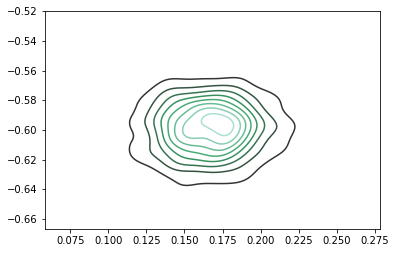

In [46]:
sns.kdeplot(samples[:,1,0,0], samples[:,1,0,1])
plt.show()

In [47]:
t = 18
params[t]

array([[ 0.3209, -0.6453]])

In [48]:
np.mean(samples[:,t], axis=0)

array([[ 0.4746, -0.4877]])